In [1]:
import scipy
from scipy.interpolate import CubicSpline as CubicSpline
from scipy.interpolate import interp1d as interp1d
import pandas as pd
import numpy as np
#интерполяция
from scipy.interpolate import interp1d
#Рисование графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
data= pd.read_csv('Nasdaq_compose_Yahoo.csv')

#Выбираем нужные столбцы
data=data[['Date', 'Adj Close']]
data.columns=['date', 'value']

In [3]:
def slice_data(df, slice_period):
    #2 сортировки, чтобы последняя дата оставалась
    return df.copy().sort_values(by='date', ascending=False)[::slice_period].sort_values(by='date').reset_index(drop=True)

In [4]:
# Сортируем по дате
df=data.sort_values(by='date')
# Преобразуем в формат времени
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,date,value
0,1990-01-02,459.299988
1,1990-01-03,460.899994
2,1990-01-04,459.399994
3,1990-01-05,458.200012
4,1990-01-08,458.700012
...,...,...
8026,2021-11-08,15982.360352
8027,2021-11-09,15886.540039
8028,2021-11-10,15622.709961
8029,2021-11-11,15704.280273


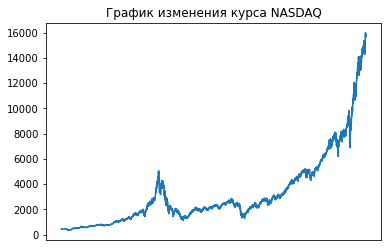

In [5]:
plt.plot(df['date'], df['value'])
plt.title('График изменения курса NASDAQ');
plt.xticks([])
plt.show()

In [6]:
def get_arange(length, step):
    return np.arange(1, length+step, step=step)

def deriv_spline(spline, n):
    # Находим производные сплайна порядка 0-3
    pp=[]
    for i in range(n):
        pp.append(spline.derivative(i))
    return pp

def calc_spline_values(xx, pp):
    # Вычисляем значения для производных сплайна
    ppf=[]
    for i in range(len(pp)):
        ppf.append(pp[i](xx))
    return ppf

def interpolate(ppf, step):
    # Задаем интервалы для интерполяции
    t=np.arange(1, ppf[0].shape[0]+1)
    pp1f_y=get_arange(ppf[0].shape[0], step=step)
    # Производим интерполяцию
    interp1=lambda x: interp1d(t, x, kind='cubic', fill_value="extrapolate")(pp1f_y) # нужен ли параметр fill_value
    deriv=[]
    for i in range(len(ppf)):
        deriv.append(interp1(ppf[i]))
    return deriv

def get_phase_portrait(x, y, step_spline=0.05,step_deriv=.01, deriv_num=4):
    #Высчитываем данные портрета и xx
    xx = get_arange(x.shape[0], step=step_spline)
    spline = CubicSpline(x, y, bc_type='clamped')
    yy=spline(xx)
    pp=deriv_spline(spline, deriv_num)
    ppf=calc_spline_values(xx, pp)
    
    deriv=interpolate(ppf, step_deriv)
    return xx, deriv

In [7]:
def get_ticks(arr, num=5):
    #Поиск нужного кол-во делений на шкалах, возвращает массив с данными
    assert num>2
    
    mask=np.linspace(0, arr.shape[0]-1, num=num).round().astype(int)
    if type(arr)==pd.core.frame.DataFrame or type(arr)==pd.core.series.Series:
        return [arr.iloc[i] for i in mask]
    else:
        return [arr[i] for i in mask]

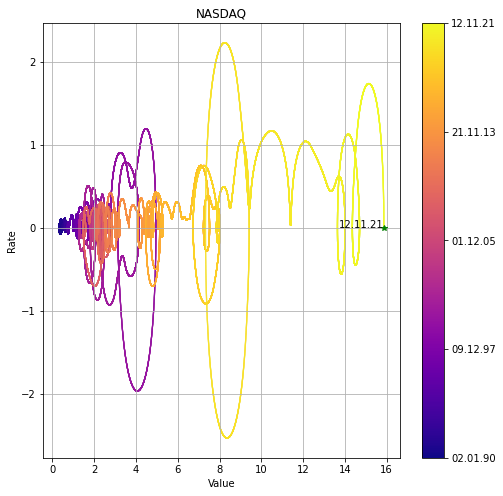

In [40]:
cmap = plt.cm.plasma
norm = plt.Normalize(x.min(), x.max())

c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

fig, ax = plt.subplots()
ax.scatter(deriv[0], deriv[1], c=c_bar, s=0.05)
cax=ax.plot(deriv[0][-1], deriv[1][-1], '*g', markersize=6)
ax.annotate(df['date'].iloc[-1].strftime('%d.%m.%y'),  xy=(deriv[0][-1], deriv[1][-1]), color='black', ha="right")
ax.set_ylabel('Rate')
ax.set_xlabel('Value')

plt.title('NASDAQ')

fig.set_figheight(8)
fig.set_figwidth(8)

# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#              cax=cax, orientation='vertical')
# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=years, orientation='vertical')
ticks_num=5
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'], ticks_num)))

plt.grid()
plt.savefig('Nasdaq_test_1.png')

In [8]:
def plot_phase_portrait(xx, dates, deriv, tt, name, ticks_num=5, save_fig_name='', y_limits=(), x_limits=(), ):
    cmap = plt.cm.plasma
    norm = plt.Normalize(xx.min(), xx.max())
    
    c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

    fig, ax = plt.subplots()
    ax.scatter(deriv[0]*1000, deriv[1], c=c_bar, s=0.05)
    cax=ax.plot(deriv[0][-1]*1000, deriv[1][-1], '*g', markersize=6)
    ax.annotate(dates.iloc[-1].strftime('%d.%m.%y'),  xy=(deriv[0][-1]*1000, deriv[1][-1]), color='black', ha="right")
    ax.set_ylabel('Rate')
    ax.set_xlabel('Value')
    
    ax.ticklabel_format(style='sci',scilimits=(-1, 4),axis='x')
    
    plt.title(name)

    fig.set_figheight(8)
    fig.set_figwidth(8)
    
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
    cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(dates, ticks_num)))
    if len(y_limits)==2:
        plt.ylim(y_limits)
    if len(x_limits)==2:
        plt.xlim(x_limits)
    plt.grid()
#     plt.show()
    if save_fig_name:
        plt.savefig(f"{save_fig_name}.png", dpi=200)

def get_filename(name, min_date, max_date, freq):
    return f"{name}_{min_date}_to_{max_date}_f_{freq}"

In [9]:
def calc_phase_portrait(df, slice_period):

    df=slice_data(df, slice_period)

    df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

    x=df.index.to_series()+1
    y=df['value']
    y=y/1000
    xx, deriv=get_phase_portrait(x,y, step_spline=.05, step_deriv=.01, deriv_num=4)
    func=deriv[0]

    step=.0005
    tt=get_arange(x.shape[0], step=step)
    return (x, y, xx, deriv, tt, slice_period)

def generate_phase_portrait(df, slices):
    data=[]
    for slice_period in slices:
        data.append(calc_phase_portrait(df, slice_period))
    return data

In [45]:
name='NASDAQ Composite'
generated_data=generate_phase_portrait(df, [1, 7, 30])

In [13]:
from itertools import chain
y_lims=list(chain(*[(min(slice_data[3][1]), max(slice_data[3][1])) for slice_data in generated_data]))
y_lims

[-1.3107661824816597,
 1.0066197352039754,
 -1.5232966388415696,
 1.1748657067326296,
 -2.535345418168563,
 2.2268084080401374]

In [14]:
# from itertools import chain
# y_lims=list(chain(*[(min(slice_data[3][1]), max(slice_data[3][1])) for slice_data in generated_data]))
# y_lims=tuple(map(np.ceil,(min(y_lims), max(y_lims))))
y_lim=(-2.7, 2.5)
x_lim=(0, 17)

In [15]:
def generate_png():
    for data in generated_data:
        x, y, xx, deriv, tt, slice_period = data

        filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)

        plot_phase_portrait(xx, df['date'], deriv, tt, f"{name} t={slice_period}", ticks_num=5, save_fig_name='./Nasdaq_img/'+filename, y_limits=y_lim, x_limits=x_lim)

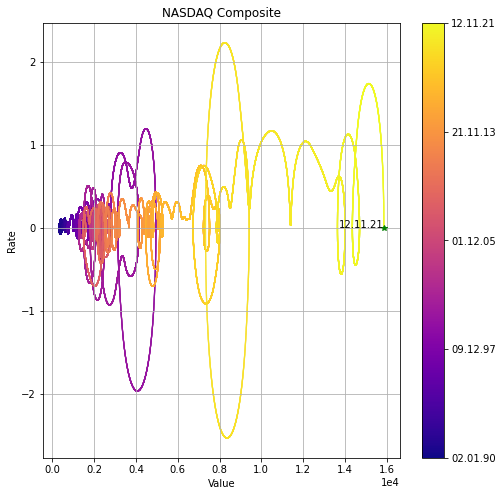

In [51]:
x, y, xx, deriv, tt, slice_period = generated_data[2]
# plot_phase_portrait(xx, df['date'], deriv, tt, f"{name} t={slice_period}", ticks_num=5)

filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)
# plot_phase_portrait(xx, df['date'], deriv, tt, f"{name} t={slice_period}", save_fig_name='./Nasdaq_img/'+'test', y_limits=y_lim, x_limits=x_lim)
plot_phase_portrait(xx, df['date'], deriv, tt, name, ticks_num=5)

In [17]:
%time generate_png()

Wall time: 5min 8s


ValueError: Image size of 333242x496 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x576 with 2 Axes>

ValueError: Image size of 333242x496 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x576 with 2 Axes>

ValueError: Image size of 333242x496 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x576 with 2 Axes>

In [46]:
deriv_1= generated_data[0][3]
deriv_7 = generated_data[1][3]
deriv_30 = generated_data[2][3]

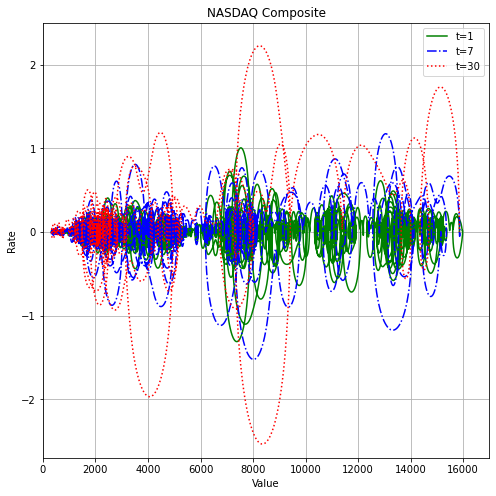

In [47]:
fig, ax = plt.subplots()
ax.plot(deriv_1[0]*1000, deriv_1[1], '-g', deriv_7[0]*1000, deriv_7[1], '-.b', deriv_30[0]*1000, deriv_30[1], ':r')
# ax.plot(deriv_30[0], deriv_30[1], ':g', deriv_7[0], deriv_7[1], '-.b', deriv_1[0], deriv_1[1], '-r')
plt.ylim(y_lim)
plt.xlim(tuple(map(lambda x: x*1000, x_lim)))
plt.title(name)
ax.set_ylabel('Rate')
ax.set_xlabel('Value')
plt.legend(['t=1', 't=7', 't=30' ], loc='best')

fig.set_figheight(8)
fig.set_figwidth(8)

filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)

# ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.grid()
# plt.savefig(f"./Nasdaq/{filename}_comparison.png", dpi=200)
plt.show()

In [54]:
start_date='01.01.1995'
end_date='01.01.2002'
date_filter=(df['date']>=pd.to_datetime(start_date, format='%d.%m.%Y')) & (df['date']<=pd.to_datetime(end_date, format='%d.%m.%Y'))
df[date_filter]

,date,value
1265,1995-01-03,743.580017
1266,1995-01-04,745.840027
1267,1995-01-05,745.659973
1268,1995-01-06,749.690002
1269,1995-01-09,752.090027
...,...,...
3023,2001-12-24,1944.479980
3024,2001-12-26,1960.699951
3025,2001-12-27,1976.420044
3026,2001-12-28,1987.260010


In [59]:
date_filter

0       False
1       False
2       False
3       False
4       False
        ...  
8026    False
8027    False
8028    False
8029    False
8030    False
Name: date, Length: 8031, dtype: bool

In [60]:
x

0        1
1        2
2        3
3        4
4        5
      ... 
263    264
264    265
265    266
266    267
267    268
Length: 268, dtype: int64

In [56]:
filtered_x = x[date_filter]
min_x, max_x = filtered_x.min(), filtered_x.max()

In [58]:
filtered_x

Series([], dtype: int64)

In [48]:
from phase_portrait import get_mask_tt
mask=get_mask_tt(x, tt, df['date'], start_date, end_date)

In [53]:
deriv_1[0].shape

(16060001,)

In [141]:
filtered_x=x[date_filter]
min_x, max_x=filtered_x.min(), filtered_x.max()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 16060001 but corresponding boolean dimension is 534001

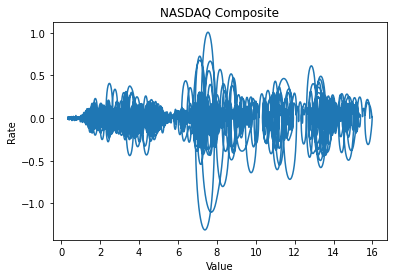

In [34]:
fig, ax = plt.subplots()
ax.plot(deriv_1[0], deriv_1[1])
# ax.plot(deriv_1[0], deriv_1[1], '-b', deriv_1[0][mask], deriv_1[1][mask], ':r')
# ax.plot(deriv_30[0], deriv_30[1], ':g', deriv_7[0], deriv_7[1], '-.b', deriv_1[0], deriv_1[1], '-r')

plt.title(name)
ax.set_ylabel('Rate')
ax.set_xlabel('Value')

plt.xlim((deriv_1[0][mask].min(), deriv_1[0][mask].max()))

fig.set_figheight(8)
fig.set_figwidth(8)

# plt.show()

In [35]:
deriv_1[0][mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 16060001 but corresponding boolean dimension is 534001

In [30]:
mask

array([False, False, False, ..., False, False, False])

In [51]:
plt.plot(tt, deriv[1], '-b', tt[mask], deriv[1][mask], 'r')

NameError: name 'mask' is not defined